Reproduce solubility model of [Creaser et al., 2021](https://doi.org/10.1016/j.chemgeo.2021.120609).
## Model formula

* $m_{anhydrite} = K_1 x_{H_2O}^j + K_1K_2 x_{H_2O}^j m_{NaCl}^q$, in which $x_{H_2O}$ is the mole fraction; $m_*$ is the solubility (molal). $K_1, K_2, j, q$ are coefficients. $m_{NaCl} = 1000\frac{x_{NaCl}}{x_{H2O}M_{NaCl}}$ (mol/kg) is the molality of NaCl. $m_{anhydrite}$ is the molality of anhydrite in unit of mol/kg, so it can also be expressed as $m_{anhydrite} = 1000 \frac{x_{anhydrite}}{x_{H2O}M_{H2O}}$, using this formula to derive the mass fraction of anhydrite.

* Coefficients and formula of $K_*$

|       | a(J/mol) | b(J/mol/K) | c(J/mol/K) | d(J/mol/K) | e(J/mol/K) | j | q |
|-------|----------|------------|------------|------------|------------|---|---|
| $K_1$ | 38849.15 | -1307.97   | 226.63     | -0.2726    | -131.318   | - | - |
| $K_2$ | 4985.14  | -8.8072    | -          | -          | 110.103    | 1 | 1 |

$-RT ln(K) = a + bT + cTlnT +dT+eTln(\frac{18.0152}{x_{H_2O}V_{mix}})$, in which $V_{mix} = \frac{18.0152x_{H_2O}+58.443(1-x_{H_2O})}{\rho_{bulk}}$ is the molar volume of the fluid ($cm^3/mol$)

### Definition

* **Molar volume**: a substance is the volume occupied by one mole of it at a given temperature and pressure. It is equal to the **molar mass** (M) divided by the **mass density** (ρ)

* **Molality**: also called **molal**, the amount of substance (in moles) of solute, $n_{solute}$, divided by the mass (in kg) of the solvent, $m_{solvent}$. Unit: mol/kg

* **Mole fraction**: moles of target substance divided by total moles involved

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import string
import pyswEOS
# print(pyswEOS.__version__)

from pyswEOS import H2ONaCl
from pyswEOS import H2O
water=H2O.cH2O()
sw=H2ONaCl.cH2ONaCl()

mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.size'] = 12
mpl.rcParams['mathtext.fontset'] = 'cm'


In [49]:
def K1K2(T_C, rho_f,x_mol_NaCl):
    # T_C: deg.C
    # rho_f: bulk density of the fluid (kg/m^3)
    # x_mol_NaCl: salinity: mol fraction
    M_H2O = 18.0152 # g/mol
    M_NaCl = 58.442 # g/mol
    T_K = T_C +273.15 # Kelvin 
    rho = rho_f * 1E-3 # g/cm^3
    x_NaCl = x_mol_NaCl
    x_H2O = 1- x_NaCl
    V_mix = (M_H2O*x_H2O + M_NaCl*x_NaCl)/rho # cm^3/mol
    rho_star = M_H2O/(x_H2O*V_mix)
    R = 8.314 # J/mol/K: gas constant
    # K1
    a,b,c,d,e = 38849.15, -1307.97, 226.63, -0.2726, -131.318
    K1 = np.exp((a + b*T_K + c*T_K*np.log(T_K) + d*T_K**2 + e*T_K*np.log(rho_star))/(-R*T_K))
    # K2
    a,b,e = 4985.14, -8.8072, 110.103
    K2 = np.exp((a + b*T_K + e*T_K*np.log(rho_star))/(-R*T_K))
    return (K1, K2)
def Solubility_Anhydrite(T_C, rho_f,x_mol_NaCl, phase_region):
    M_H2O = 18.0152 # g/mol
    x_mol_H2O = 1 - x_mol_NaCl
    m_NaCl = x_mol_NaCl/(x_mol_H2O*M_H2O)*1000 # mol/kg !!!: molality of NaCl,  mole of NaCl divided by mass of H2O
    solubility = np.NaN
    if(phase_region==0):
        K = K1K2(T[i], rho, x_mol_NaCl)
        solubility = (K[0]*x_mol_H2O + K[0]*K[1]*x_mol_H2O*m_NaCl) # mol/kg
    return solubility
def SolubilityProduct_Anhydrite(T_C, rho_f,x_mol_NaCl, phase_region):
    # Solubility product K_sp = Cca*Cso4 (mass fraction of Ca times mass fraction of SO4)
    M_H2O = 18.0152 # g/mol
    M_Ca = 40.078 # g/mol
    M_SO4 = 96.065 # g/mol
    M_NaCl = 58.442 # g/mol
    
    x_mol_H2O = 1 - x_mol_NaCl
    m_NaCl = x_mol_NaCl/(x_mol_H2O*M_H2O)*1000 # mol/kg !!!: molality of NaCl,  mole of NaCl divided by mass of H2O
    solubility = np.NaN
    if(phase_region==0):
        K = K1K2(T[i], rho, x_mol_NaCl)
        solubility = (K[0]*x_mol_H2O + K[0]*K[1]*x_mol_H2O*m_NaCl) # mol/kg
    # calculate K_sp 
    x_mol_anhydrite = solubility/1000 * (x_mol_H2O*M_H2O)
    m_total = x_mol_H2O*M_H2O + x_mol_NaCl*M_NaCl + x_mol_anhydrite*(M_Ca + M_SO4)
    m_Ca = x_mol_anhydrite*M_Ca 
    m_SO4 = x_mol_anhydrite*M_SO4
    K_sp = m_Ca/m_total * m_SO4/m_total
    return K_sp
def Ksp_simple(T_C):
    T_K = T_C +273
    K_sp = 6.124*1E-12*np.exp(5.0594E3/(T_K))
    return K_sp

### Fig. 3: anhydrite solubility (molal) as a function of temperature at constant salinity and pressure


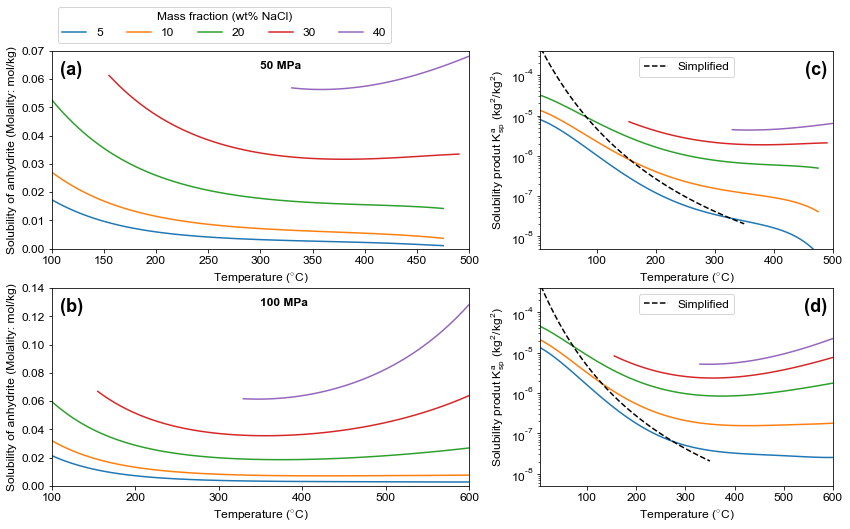

In [98]:
fig,axes=plt.subplots(2,2,figsize=(14,8),gridspec_kw={'wspace':0.2,'hspace':0.2,'width_ratios':[1,0.7]})

X=[5, 10, 20, 30, 40] # wt% NaCl
P=[50,100] #MPa
Tmax=[500,600]
ymax=[0.07, 0.14]
for j in range(0,len(P)):
    p0=P[j]
    ax=axes[j][0]
    T=np.linspace(5, Tmax[j], 100)
    for x in X:
        m_anhydrite = np.zeros_like(T)
        K_sp = np.zeros_like(T) # calculate K_sp and compare to the previous simple formula used in Guo et al.(2020: 10.1029/2019JB019035)
        for i in range(0,len(T)):
            Prop=sw.prop_pTX(p0*1E6, T[i]+273.15, x/100)
            rho = Prop.Rho
            x_NaCl = Prop.X_l
            phase_region = Prop.Region
            x_mol_NaCl = sw.Wt2Mol(x_NaCl)
            m_anhydrite[i]=Solubility_Anhydrite(T[i], rho, x_mol_NaCl, phase_region)
            K_sp[i]=SolubilityProduct_Anhydrite(T[i], rho, x_mol_NaCl, phase_region)
        ax.plot(T, m_anhydrite,label=x)
        axes[j][1].semilogy(T, K_sp)
    for ax in axes[j,:]:
        ax.set_xlim(100, T.max())
        ax.set_xlabel('Temperature ($^{\circ}$C)')
    axes[j][0].set_ylim(0,ymax[j])
    axes[j][0].set_ylabel('Solubility of anhydrite (Molality: mol/kg)')
    axes[j][0].text(0.5, 0.95, '%d MPa'%(P[j]), transform=axes[j][0].transAxes, va='top', fontsize=12,fontweight='bold')
    axes[j][0].text(0.02, 0.95, '(%s)'%(chr(97+j)), transform=axes[j][0].transAxes, va='top', fontsize=18,fontweight='bold')
    axes[j][1].text(0.98, 0.95, '(%s)'%(chr(97+j+2)), transform=axes[j][1].transAxes, va='top',ha='right', fontsize=18,fontweight='bold')
    axes[j][1].set_ylim(5E-9, 4E-4)
    axes[j][1].set_ylabel('Solubility produt K$_{\mathregular{sp}}^{\mathregular{a}}$ (kg$^{\mathregular{2}}$/kg$^{\mathregular{2}}$)')
axes[0][0].legend(title='Mass fraction (wt% NaCl)',ncol=len(X), loc='lower left',bbox_to_anchor=(0,1.01))

# plot simplifide K_sp of anhydrite 
T=np.linspace(0,350,100)
ksp = Ksp_simple(T)
for ax in axes[:,1]:
    ax.semilogy(T, ksp, color='k',ls='dashed',label='Simplified')
    ax.set_xlim(5,ax.get_xlim()[1])
    ax.legend(loc='upper center')
plt.show()

### Fig. 4: anhydrite solubility (molal) as a function of pressure with constant salinity and temperature

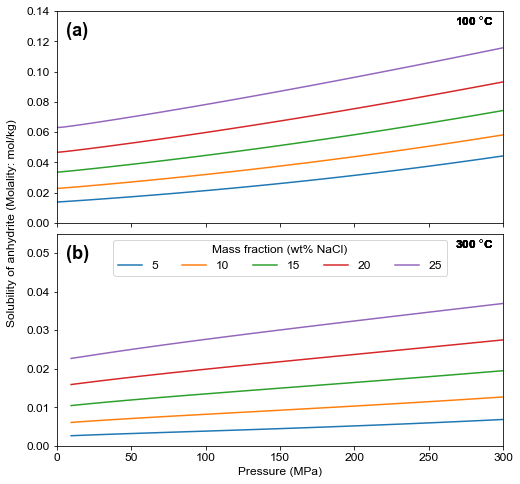

In [101]:
fig,axes=plt.subplots(2,1,figsize=(8,8),gridspec_kw={'wspace':0.2,'hspace':0.05,'width_ratios':[1]}, sharex=True)

P=np.linspace(0.5, 300, 100) # MPa 
T = [100, 300] #deg.C
X = [5, 10, 15, 20, 25] # wt% NaCl
for i in range(0,len(T)):
    T0=T[i]
    ax=axes[i]
    for j in range(0,len(X)):
        X0=X[j]
        m_anhydrite=np.zeros_like(P)
        for k in range(0,len(P)):
            Prop=sw.prop_pTX(P[k]*1E6, T0+273.15, X0/100)
            rho = Prop.Rho
            x_NaCl = Prop.X_l
            phase_region = Prop.Region
            x_mol_NaCl = sw.Wt2Mol(x_NaCl)
            m_anhydrite[k]=Solubility_Anhydrite(T0, rho, x_mol_NaCl, phase_region)
        ax.plot(P, m_anhydrite,label=X0)
        ax.text(0.98,0.98,'%d $^{\circ}$C'%(T0), transform=ax.transAxes, va='top',ha='right',fontsize=12,fontweight='bold')
    ax.text(0.02, 0.95, '(%s)'%(chr(97+i)), transform=ax.transAxes, va='top', fontsize=18,fontweight='bold')
ax.set_xlabel('Pressure (MPa)')
ax.legend(title='Mass fraction (wt% NaCl)',ncol=len(X),loc='upper center')
ax.set_xlim(0,300)
axes[0].set_ylim(0,0.14)
axes[1].set_ylim(0,0.055)
axes[0].text(-0.1,0,'Solubility of anhydrite (Molality: mol/kg)',transform=axes[0].transAxes, rotation=90,va='center',ha='center',zorder=5)

plt.show()

### Fig. 5: anhydrite solubility (molal) as a function of salinity with constant pressure and temperature

Something is different to the Fig. 5 in [Creaser et al., 2021](https://doi.org/10.1016/j.chemgeo.2021.120609).

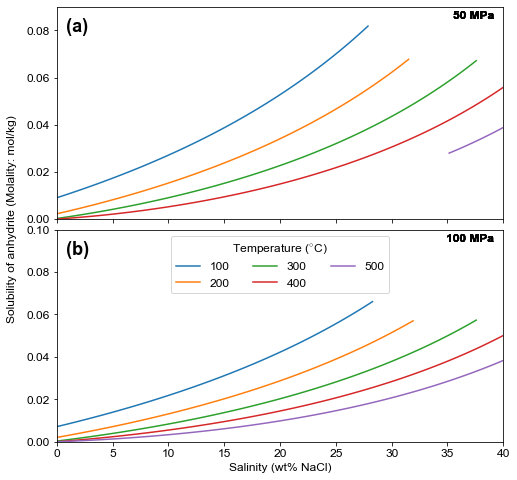

In [104]:
fig,axes=plt.subplots(2,1,figsize=(8,8),gridspec_kw={'wspace':0.2,'hspace':0.05,'width_ratios':[1]}, sharex=True)

P=[50, 100] # MPa 
T = [100, 200, 300, 400, 500] #deg.C
X = np.linspace(0,40,100) # wt% NaCl
for i in range(0,len(P)):
    P0=P[i]
    ax=axes[i]
    for j in range(0,len(T)):
        T0=T[j]
        m_anhydrite=np.zeros_like(X)
        for k in range(0,len(X)):
            Prop=sw.prop_pTX(P0*1E6, T0+273.15, X[k]/100)
            rho = Prop.Rho
            x_NaCl = Prop.X_l
            phase_region = Prop.Region
            x_mol_NaCl = sw.Wt2Mol(x_NaCl)
            m_anhydrite[k]=Solubility_Anhydrite(T0, rho, x_mol_NaCl, phase_region)
        ax.plot(X, m_anhydrite,label=T0)
        ax.text(0.98,0.98,'%d MPa'%(P0), transform=ax.transAxes, va='top',ha='right',fontsize=12,fontweight='bold')
    ax.text(0.02, 0.95, '(%s)'%(chr(97+i)), transform=ax.transAxes, va='top', fontsize=18,fontweight='bold')
ax.set_xlabel('Salinity (wt% NaCl)')
ax.legend(title='Temperature ($^{\circ}$C)',ncol=3,loc='upper center')
ax.set_xlim(0,40)
axes[0].set_ylim(0,0.09)
axes[1].set_ylim(0,0.1)
axes[0].text(-0.1,0,'Solubility of anhydrite (Molality: mol/kg)',transform=axes[0].transAxes, rotation=90,va='center',ha='center',zorder=5)

plt.show()

### Fig. 6: anhydrite solubility (molal) in P-T space with constant salinity

In [130]:
X=[5, 10, 20, 30] # wt% NaCl
T=np.linspace(1, 800, 800) # deg.C
P = np.linspace(0.5, 300, 300)

PP,TT = np.meshgrid(P,T)
m_anhydrite={}
phase_regions={}
for x0 in X:
    m_anhydrite[x0]=np.zeros_like(TT)
    phase_regions[x0]=np.zeros_like(TT)
    for i in range(0,TT.shape[0]):
        for j in range(0,TT.shape[1]):
            Prop=sw.prop_pTX(PP[i][j]*1E6, TT[i][j]+273.15, x0/100)
            rho = Prop.Rho
            x_NaCl = Prop.X_l
            phase_region = Prop.Region
            x_mol_NaCl = sw.Wt2Mol(x_NaCl)
            m_anhydrite[x0][i][j]=Solubility_Anhydrite(T0, rho, x_mol_NaCl, phase_region)
            phase_regions[x0][i][j]=phase_region

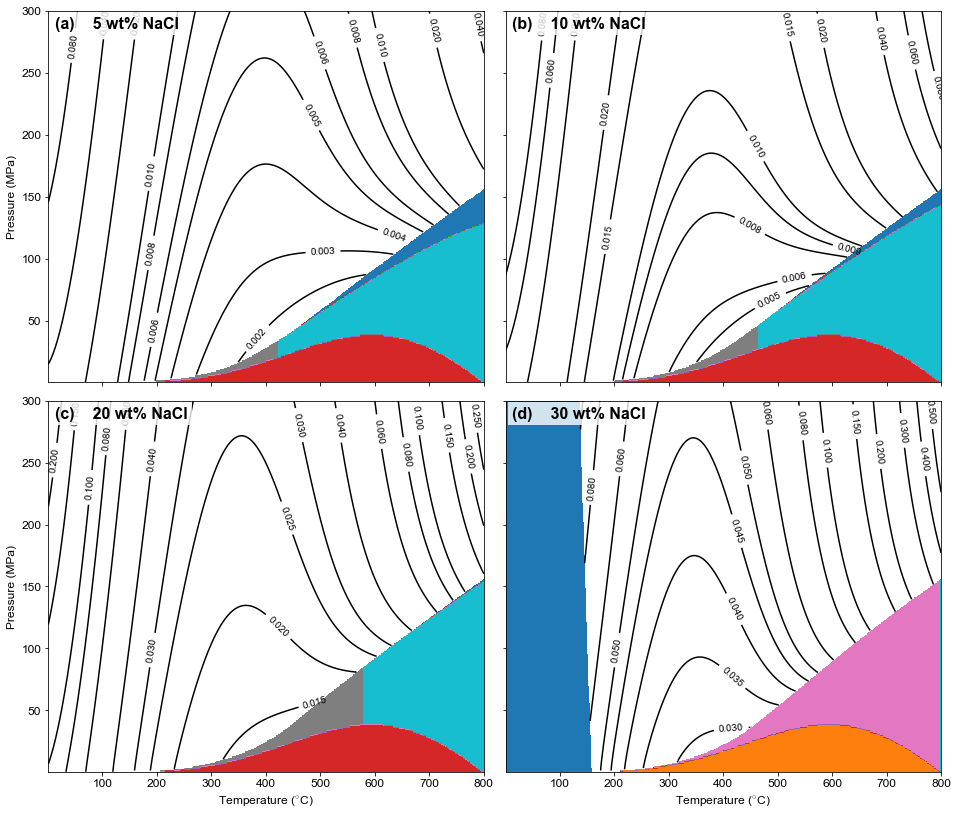

In [154]:
fig,axes=plt.subplots(2,2,figsize=(16,14),gridspec_kw={'wspace':0.05,'hspace':0.05,'width_ratios':[1,1]}, sharex=True, sharey=True)
ax=axes[0][0]
# ax.contourf(TT,PP,m_anhydrite)
levels=[[0.002, 0.003, 0.004, 0.005, 0.006, 0.008, 0.01, 0.02, 0.04, 0.08],
        [0.005, 0.006, 0.008, 0.009, 0.01, 0.015, 0.02, 0.04, 0.06, 0.08],
        [0.015, 0.02, 0.025, 0.03, 0.04, 0.06, 0.08, 0.1, 0.15, 0.2, 0.25],
        [0.03, 0.035, 0.04, 0.045, 0.05, 0.06, 0.08, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5]]
for i, x0 in enumerate(X):  
    phase_regions[x0][phase_regions[x0]==0]=np.NaN
    ax=axes[i//2][i%2]
    ax.contourf(TT,PP, phase_regions[x0], cmap='tab10')
    CS=ax.contour(TT,PP,m_anhydrite[x0],levels=levels[i], colors='k')
    ax.clabel(CS, inline=True, fontsize=10)
    ax.text(0.015, 0.985, '(%s)    %s wt%% NaCl'%(chr(97+i),x0),transform=ax.transAxes,bbox={'fc':'w','ec':'None','alpha':0.8},va='top',ha='left',fontsize=16,fontweight='bold', zorder=10)
for i in range(0,2):
    axes[i][0].set_ylabel('Pressure (MPa)')
    axes[-1][i].set_xlabel('Temperature ($^{\circ}$C)')
plt.show()